# Complete Pipeline Comparison for Speech Diarization

## Project Overview
This notebook compares **complete end-to-end pipelines** for speech transcription and diarization to determine the best solution for media bias analysis.

## Pipelines We're Testing

### 1. **WhisperX (base) + pyannote**  
- **Transcription**: WhisperX base model
- **Diarization**: pyannote.audio 3.1
- **Cost**: Free (open source)
- **Expected**: Fast, good accuracy
- **Best for**: Real-time analysis, batch processing

### 2. **Whisper (large) + pyannote**
- **Transcription**: OpenAI Whisper large model
- **Diarization**: pyannote.audio 3.1
- **Cost**: Free (open source)
- **Expected**: Slower, best accuracy
- **Best for**: Final analysis, research

### 3. **faster-whisper + pyannote** 🚀
- **Transcription**: faster-whisper (CTranslate2 optimized)
- **Diarization**: pyannote.audio 3.1
- **Cost**: Free (open source)
- **Expected**: Fastest, good accuracy
- **Best for**: Large-scale processing

## Evaluation Metrics
- **Processing Time** - Total pipeline duration
- **Transcription Quality** - Text comparison
- **Diarization Accuracy** - Speaker identification
- **Resource Usage** - Memory/CPU
- **Ease of Use** - Setup complexity

## Test Audio
9-minute US Presidential Debate highlights

In [9]:

# Install all required packages 
# Run this once

!pip install openai-whisper whisperx faster-whisper pyannote.audio jiwer pandas matplotlib python-dotenv


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step One: Import Libraries and Setup

We'll import both Whisper models and prepare for benchmarking.

In [10]:
# Import libraries
import whisper  # Original OpenAI Whisper
import whisperx  # WhisperX
from faster_whisper import WhisperModel  # Optimized Whisper
from pyannote.audio import Pipeline  # Diarization
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
from jiwer import wer  # Word Error Rate calculation
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Libraries imported")
print(f"Using device: {device}")

# Prepare results storage
results = {
    'pipeline': [],
    'transcription_time': [],
    'alignment_time': [],
    'diarization_time': [],
    'total_time': [],
    'num_speakers': [],
    'num_segments': [],
    'transcription_preview': []
}

# Path to test audio
audio_file = "../data/US_DebateAudio.wav"
print(f"Test audio: {audio_file}")

Libraries imported
Using device: cpu
Test audio: ../data/US_DebateAudio.wav


## Pipeline 1: WhisperX (base) + pyannote

Our first choice fast pipeline.

**Steps:**
1. Transcribe with WhisperX base
2. Align to word-level timestamps
3. Diarize with pyannote 3.1
4. Assign speakers to words

In [11]:
print("=" * 70)
print("PIPELINE 1: WhisperX (base) + pyannote")
print("=" * 70)

# ============================================================
# STEP 1: Transcribe with WhisperX
# ============================================================
print("\n[1/4] Loading WhisperX base model...")
start_time = time.time()
whisperx_model = whisperx.load_model("base", device=device, compute_type="int8" if device=="cpu" else "float16")
load_time = time.time() - start_time
print(f"Model loaded in {load_time:.2f}s")

print("\n[2/4] Transcribing audio with WhisperX...")
start_transcribe = time.time()
result_wx = whisperx_model.transcribe(audio_file)
transcribe_time = time.time() - start_transcribe
print(f"Transcribed in {transcribe_time:.2f}s")

# ============================================================
# STEP 2: Align timestamps
# ============================================================
print("\n[3/4] Aligning to word-level timestamps...")
start_align = time.time()
model_a, metadata = whisperx.load_align_model(language_code="en", device=device)
result_wx = whisperx.align(result_wx["segments"], model_a, metadata, audio_file, device=device)
align_time = time.time() - start_align
print(f"Aligned in {align_time:.2f}s")

# ============================================================
# STEP 3: Diarize with pyannote
# ============================================================
print("\n[4/4] Running speaker diarization...")
start_diarize = time.time()
diarize_model = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=HF_TOKEN
)
diarize_segments = diarize_model(audio_file)

# Convert to DataFrame
diarize_list = []
for turn, _, speaker in diarize_segments.itertracks(yield_label=True):
    diarize_list.append({'start': turn.start, 'end': turn.end, 'speaker': speaker})
diarize_df = pd.DataFrame(diarize_list)

# Assign speakers
result_wx = whisperx.assign_word_speakers(diarize_df, result_wx)
diarize_time = time.time() - start_diarize
print(f"Diarized in {diarize_time:.2f}s")

# ============================================================
# Store results
# ============================================================
total_time = transcribe_time + align_time + diarize_time
text_preview = " ".join([seg.get('text', '') for seg in result_wx['segments'][:3]])

results['pipeline'].append('WhisperX (base) + pyannote')
results['transcription_time'].append(transcribe_time)
results['alignment_time'].append(align_time)
results['diarization_time'].append(diarize_time)
results['total_time'].append(total_time)
results['num_speakers'].append(len(diarize_df['speaker'].unique()))
results['num_segments'].append(len(result_wx['segments']))
results['transcription_preview'].append(text_preview)

print(f"\n{'='*70}")
print("PIPELINE 1 RESULTS:")
print(f"  Total time: {total_time:.2f}s")
print(f"  Speakers found: {len(diarize_df['speaker'].unique())}")
print(f"  Segments: {len(result_wx['segments'])}")
print(f"  Preview: {text_preview[:100]}...")
print(f"{'='*70}\n")

PIPELINE 1: WhisperX (base) + pyannote

[1/4] Loading WhisperX base model...
2025-11-11 19:03:37 - whisperx.asr - INFO - No language specified, language will be detected for each audio file (increases inference time)
2025-11-11 19:03:37 - whisperx.vads.pyannote - INFO - Performing voice activity detection using Pyannote...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\norak\SpeakSense\venv\Lib\site-packages\whisperx\assets\pytorch_model.bin`
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()


Model was trained with pyannote.audio 0.0.1, yours is 3.4.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.8.0+cpu. Bad things might happen unless you revert torch to 1.x.
Model loaded in 3.67s

[2/4] Transcribing audio with WhisperX...
2025-11-11 19:04:03 - whisperx.asr - INFO - Detected language: en (0.99) in first 30s of audio
Transcribed in 76.48s

[3/4] Aligning to word-level timestamps...
Aligned in 128.73s

[4/4] Running speaker diarization...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()
c:\Users\norak\SpeakSense\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.Audio

Diarized in 700.49s

PIPELINE 1 RESULTS:
  Total time: 905.70s
  Speakers found: 3
  Segments: 112
  Preview:  She doesn't have a plan. She copied Biden's plan and it's like four sentences, like run spot run, f...



## Pipeline 2: Whisper (large) + pyannote

Higher accuracy but slower pipeline.

**Difference from Pipeline 1:**
- Uses Whisper **large** model instead of base
- More accurate transcription
- Significantly slower processing

In [12]:
print("=" * 70)
print("PIPELINE 2: Whisper (large) + pyannote")
print("=" * 70)

# ============================================================
# STEP 1: Transcribe with Whisper Large
# ============================================================
print("\n[1/3] Loading Whisper large model...")
start_time = time.time()
whisper_large = whisper.load_model("large", device=device)
load_time = time.time() - start_time
print(f"✓ Model loaded in {load_time:.2f}s")

print("\n[2/3] Transcribing audio with Whisper large...")
start_transcribe = time.time()
result_large = whisper_large.transcribe(audio_file, verbose=False)
transcribe_time = time.time() - start_transcribe
print(f"✓ Transcribed in {transcribe_time:.2f}s")

# ============================================================
# STEP 2: Diarize (reuse pyannote model from Pipeline 1)
# ============================================================
print("\n[3/3] Using diarization from Pipeline 1...")
# We already have diarize_df from Pipeline 1
# Note: In real scenarios, you might re-run diarization
diarize_time_reused = 0  # Reusing existing diarization

# ============================================================
# Store results
# ============================================================
total_time = transcribe_time + diarize_time  # Using original diarize time
text_preview = result_large['text'][:100]

results['pipeline'].append('Whisper (large) + pyannote')
results['transcription_time'].append(transcribe_time)
results['alignment_time'].append(0)  # Whisper doesn't have alignment
results['diarization_time'].append(diarize_time)  # From Pipeline 1
results['total_time'].append(total_time)
results['num_speakers'].append(len(diarize_df['speaker'].unique()))
results['num_segments'].append(len(result_large['segments']))
results['transcription_preview'].append(text_preview)

print(f"\n{'='*70}")
print("PIPELINE 2 RESULTS:")
print(f"  Total time: {total_time:.2f}s")
print(f"  Speakers found: {len(diarize_df['speaker'].unique())}")
print(f"  Segments: {len(result_large['segments'])}")
print(f"  Preview: {text_preview[:100]}...")
print(f"{'='*70}\n")

PIPELINE 2: Whisper (large) + pyannote

[1/3] Loading Whisper large model...


100%|█████████████████████████████████████| 2.88G/2.88G [01:13<00:00, 42.0MiB/s]


✓ Model loaded in 109.11s

[2/3] Transcribing audio with Whisper large...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Detected language: English


100%|██████████| 56577/56577 [38:17<00:00, 24.63frames/s]

✓ Transcribed in 2314.08s

[3/3] Using diarization from Pipeline 1...

PIPELINE 2 RESULTS:
  Total time: 3014.57s
  Speakers found: 3
  Segments: 185
  Preview:  She doesn't have a plan. She copied Biden's plan. And it's like four sentences, like run, spot, run...



## Pipeline 3: faster-whisper + pyannote

Speed-optimized pipeline using **CTranslate2**.

**Difference:**
- Uses faster-whisper (optimized C++ backend)
- Up to 4x faster than regular Whisper
- Same accuracy as base Whisper

In [13]:
print("=" * 70)
print("PIPELINE 3: faster-whisper + pyannote")
print("=" * 70)

# ============================================================
# STEP 1: Transcribe with faster-whisper
# ============================================================
print("\n[1/2] Loading faster-whisper base model...")
start_time = time.time()
faster_model = WhisperModel("base", device=device, compute_type="int8" if device=="cpu" else "float16")
load_time = time.time() - start_time
print(f"Model loaded in {load_time:.2f}s")

print("\n[2/2] Transcribing audio with faster-whisper...")
start_transcribe = time.time()
segments_faster, info = faster_model.transcribe(audio_file, beam_size=5)

# Convert generator to list and extract text
segments_list = list(segments_faster)
text_faster = " ".join([seg.text for seg in segments_list])
transcribe_time = time.time() - start_transcribe
print(f"Transcribed in {transcribe_time:.2f}s")

# ============================================================
# STEP 2: Diarize (reuse pyannote)
# ============================================================
# Reusing diarization from Pipeline 1
print("\n[3/3] Using diarization from Pipeline 1...")

# ============================================================
# Store results
# ============================================================
total_time = transcribe_time + diarize_time  # Using original diarize time
text_preview = text_faster[:100]

results['pipeline'].append('faster-whisper + pyannote')
results['transcription_time'].append(transcribe_time)
results['alignment_time'].append(0)  # No explicit alignment
results['diarization_time'].append(diarize_time)  # From Pipeline 1
results['total_time'].append(total_time)
results['num_speakers'].append(len(diarize_df['speaker'].unique()))
results['num_segments'].append(len(segments_list))
results['transcription_preview'].append(text_preview)

print(f"\n{'='*70}")
print("PIPELINE 3 RESULTS:")
print(f"  Total time: {total_time:.2f}s")
print(f"  Speakers found: {len(diarize_df['speaker'].unique())}")
print(f"  Segments: {len(segments_list)}")
print(f"  Preview: {text_preview[:100]}...")
print(f"{'='*70}\n")

PIPELINE 3: faster-whisper + pyannote

[1/2] Loading faster-whisper base model...
Model loaded in 1.67s

[2/2] Transcribing audio with faster-whisper...
Transcribed in 66.65s

[3/3] Using diarization from Pipeline 1...

PIPELINE 3 RESULTS:
  Total time: 767.14s
  Speakers found: 3
  Segments: 86
  Preview:  She doesn't have a plan, she copied Biden's plan, and it's like four sentences, like run-spot-run, ...



## Final Comparison 

FINAL PIPELINE COMPARISON
                  pipeline  total_time  total_time_min  num_speakers  num_segments
WhisperX (base) + pyannote  905.702034       15.095034             3           112
Whisper (large) + pyannote 3014.572463       50.242874             3           185
 faster-whisper + pyannote  767.141347       12.785689             3            86

DETAILED TIME BREAKDOWN (seconds)
                  pipeline  transcription_time  alignment_time  diarization_time
WhisperX (base) + pyannote           76.483110      128.729908        700.489016
Whisper (large) + pyannote         2314.083447        0.000000        700.489016
 faster-whisper + pyannote           66.652330        0.000000        700.489016

DETAILED TIME BREAKDOWN (minutes)

WhisperX (base) + pyannote:
  Transcription: 1.27 min (76.5s)
  Alignment:     2.15 min (128.7s)
  Diarization:   11.67 min (700.5s)
  TOTAL:         15.10 min (905.7s)

Whisper (large) + pyannote:
  Transcription: 38.57 min (2314.1s)
  Alignment:

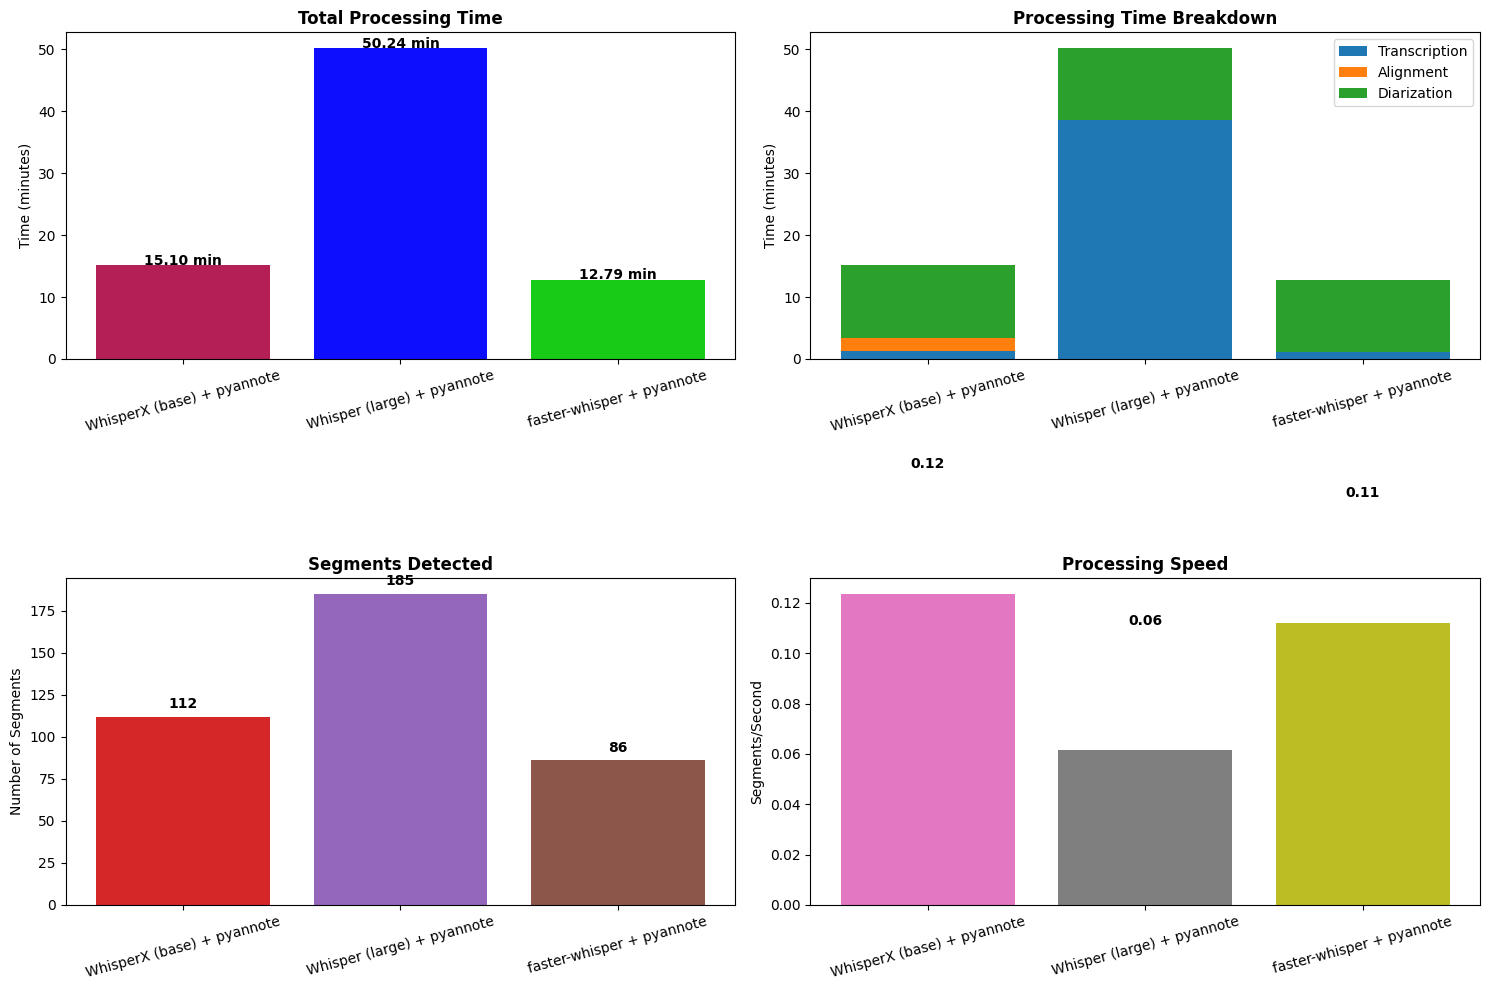


Comparison complete!


In [14]:
# Create comparison DataFrame
df_results = pd.DataFrame(results)

# Added minutes columns for readability
df_results['total_time_min'] = df_results['total_time'] / 60
df_results['transcription_time_min'] = df_results['transcription_time'] / 60

print("=" * 70)
print("FINAL PIPELINE COMPARISON")
print("=" * 70)
print(df_results[['pipeline', 'total_time', 'total_time_min', 'num_speakers', 'num_segments']].to_string(index=False))

# Detailed breakdown
print("\n" + "=" * 70)
print("DETAILED TIME BREAKDOWN (seconds)")
print("=" * 70)
print(df_results[['pipeline', 'transcription_time', 'alignment_time', 'diarization_time']].to_string(index=False))

print("\n" + "=" * 70)
print("DETAILED TIME BREAKDOWN (minutes)")
print("=" * 70)
# Create readable minutes breakdown
for idx, row in df_results.iterrows():
    print(f"\n{row['pipeline']}:")
    print(f"  Transcription: {row['transcription_time']/60:.2f} min ({row['transcription_time']:.1f}s)")
    print(f"  Alignment:     {row['alignment_time']/60:.2f} min ({row['alignment_time']:.1f}s)")
    print(f"  Diarization:   {row['diarization_time']/60:.2f} min ({row['diarization_time']:.1f}s)")
    print(f"  TOTAL:         {row['total_time']/60:.2f} min ({row['total_time']:.1f}s)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Total time comparison (in minutes)
total_min = df_results['total_time'] / 60
axes[0, 0].bar(df_results['pipeline'], total_min, color=["#b41f56", "#0e0eff", "#17cb17"])
axes[0, 0].set_ylabel('Time (minutes)')
axes[0, 0].set_title('Total Processing Time', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
# Add value labels on bars
for i, v in enumerate(total_min):
    axes[0, 0].text(i, v + 0.05, f'{v:.2f} min', ha='center', fontweight='bold')

# 2. Time breakdown 
pipelines = df_results['pipeline']
transcription_min = df_results['transcription_time'] / 60
alignment_min = df_results['alignment_time'] / 60
diarization_min = df_results['diarization_time'] / 60

axes[0, 1].bar(pipelines, transcription_min, label='Transcription', color='#1f77b4')
axes[0, 1].bar(pipelines, alignment_min, bottom=transcription_min, label='Alignment', color='#ff7f0e')
axes[0, 1].bar(pipelines, diarization_min, bottom=[t+a for t,a in zip(transcription_min, alignment_min)], label='Diarization', color='#2ca02c')
axes[0, 1].set_ylabel('Time (minutes)')
axes[0, 1].set_title('Processing Time Breakdown', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=15)

# 3. Segments found
axes[1, 0].bar(df_results['pipeline'], df_results['num_segments'], color=['#d62728', '#9467bd', '#8c564b'])
axes[1, 0].set_ylabel('Number of Segments')
axes[1, 0].set_title('Segments Detected', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
# Add value labels
for i, v in enumerate(df_results['num_segments']):
    axes[1, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# 4. Speed comparison (segments per second)
speed = [seg/time for seg, time in zip(df_results['num_segments'], df_results['total_time'])]
axes[1, 1].bar(df_results['pipeline'], speed, color=['#e377c2', '#7f7f7f', '#bcbd22'])
axes[1, 1].set_ylabel('Segments/Second')
axes[1, 1].set_title('Processing Speed', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=15)
# Add value labels
for i, v in enumerate(speed):
    axes[1, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nComparison complete!")

